# Epidemics and Signal Processing

In [94]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as sp

import seaborn as sns
sns.set()

In [115]:
plt.rcParams["figure.figsize"] = (14,4)
plt.rcParams['lines.linewidth'] = 3

## The basic reproduction number

The propagation mechanism of an epidemic such as the one caused by SARS-CoV-2 virus can be roughly modeled, at least in its inital phase, as a process in which each infected individual will eventually transmit the disease to an average of $R_0$ healthy people; these newly infected patients will, in turn, infect $R_0$ healthy individuals _each_, and so on, creating a pernicious positive feedback in the system. The constant $R_0$ is called the **basic reproduction number** for a virus and, if $R_0 > 1$, the propagation will have an exponential growth.

This model is of course an oversimplification in that it assumes an infinite supply of healthy individuals; in reality, as the number of infected people increases, the number of potential candidates for contagion becomes smaller, either via acquired immunization or death, so that $R_0$ is not a constant. But for now, let's concentrate on the initial phase, where this simple model holds rather well.

In signal processing terms, the infection mechanism is equivalent to a first-order recursive filter. Assume that each infected person spreads the virus _over a single day_ and then dies (or is no longer contagious) and assume that an initial patient zero appears at day $n=0$. The number of newly infected people per day is described by the difference equation

$$y[n] = \delta[n] + R_0 y[n-1]$$

that is, by an IIR filter with a single pole in $R_0$:

$$H(z) = \frac{1}{1 - R_0z^{-1}}$$


The output of this filter is simply

$$y[n] = R_0^n u[n]$$ 

and so for values of $R_0 < 1$ the epidemics will eventually die out, whereas for $R_0 > 1$, the propagation will be exponential and unbounded.

In [456]:
def delta(N):
    # just a delta sequence of length N
    return np.r_[1, np.zeros(N-1)]

In [457]:
def contagion(R0, N):
    # simple contagion model
    return sp.lfilter([1], [1, -R0], delta(N))

It is estimated that for SARS-CoV-2 $R_0 \approx 2.5$. Using this value in the simple model above, where contagion spreads in a single day, we will reach a _million_ new daily infections after just 16 days:

In [526]:
SC_R0 = 2.5
D = int(np.ceil(np.log(1E06)/np.log(SC_R0)))
print(D)

16


We can plot the exponential progression of the daily contagion like so:

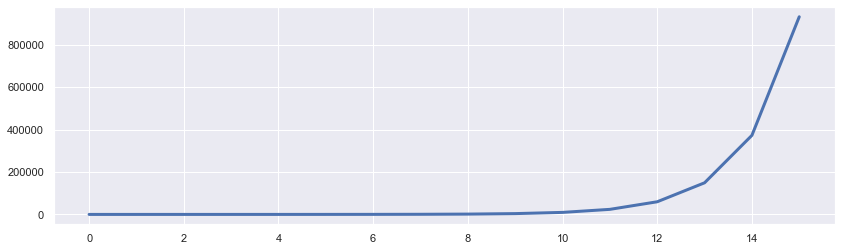

In [527]:
plt.plot(contagion(SC_R0, D));

We may be also be interested in knowing the _cumulative_ number of infected people since the beginning of the epidemic. For this, we just add to the output of the recursive filter an integrator with transfer function

$$H(z) = \frac{1}{1 - z^{-1}}$$

In [528]:
def total_infected(daily_new_cases):
    return sp.lfilter([1], [1, -1], daily_new_cases)

Note at any rate that this  does not shift the exponential trend by much:

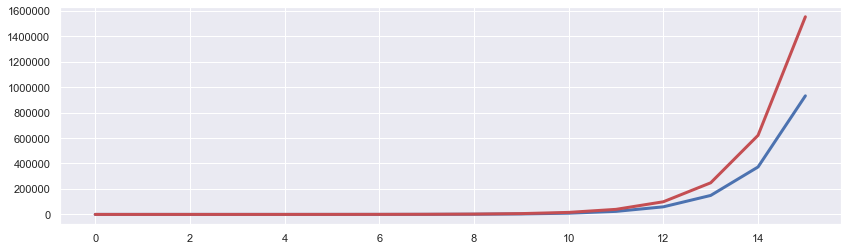

In [529]:
plt.plot(contagion(SC_R0, D));
plt.plot(total_infected(contagion(SC_R0, D)), 'r');

## The COVID19 epidemic

The actual infectiousness of SARS-CoV-2, however, is not concentrated in a single day but follows a curve that rises and falls with the duration of the sickness, as shown in this figure ([source](https://medium.com/@tomaspueyo/coronavirus-the-hammer-and-the-dance-be9337092b56)):

![title](covid.png)

We can model this with an IIR filter with a longer feedback loop and transfer function

$$H(z) = \frac{1}{1 - \sum_{k=1}^{M}a_k z^{-k}}$$

where the $a_k$'s are the daily values in the above charts. Using a rough approximation over 12 days we have:

In [530]:
a_sc = np.array([1, -.1, -.15, -.25, -.26, -.34, -.42, -.25, -.2, -.15, -.1, -.1, -.1])

def covid(N):
    return sp.lfilter([1], a_sc, delta(N))

and we can see that, with this less aggressive pattern, the number of newly infected people per day grows much more slowly at first...

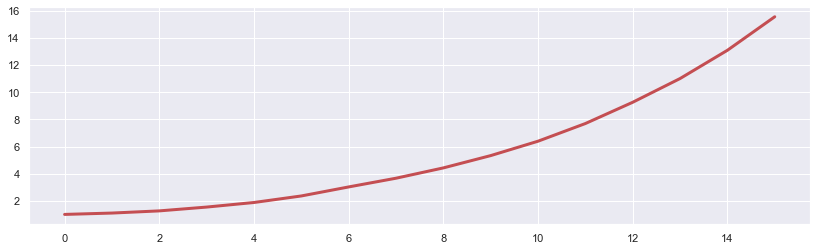

In [531]:
plt.plot(total_infected(covid(D)), 'r');

... but the exponential trend is there and it will inexorably lead to disaster: it will take 83 days but in the end we will reach the million mark.

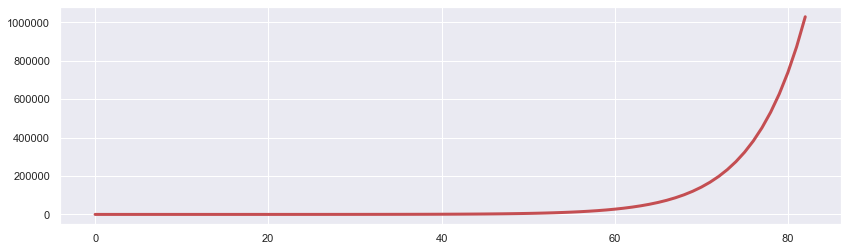

In [532]:
D_m = 83
plt.plot(total_infected(covid(D_m)), 'r');

### Social distancing

The idea of social distancing is predicated on the fact that $R_0$ is dependent on the number of encounters between a sick individual and healthy people. By reducing the number of encounters, we proportionally reduce the reproduction number. Let's assume that we can reduce the social interaction of every individual by a factor $0 < \rho \leq 1$:

In [533]:
def covid_q(N, rho):
    h = (1 - rho) * a_sc
    # first element of recursive coefficients must be one:
    h[0] = 1
    return sp.lfilter([1], h , delta(N))

With this, let's look at the how many new infections per day we have after 83 days: with a reduction of social activity by 25% we have this

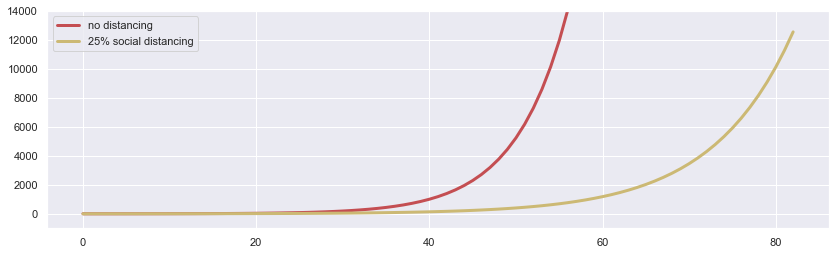

In [534]:
plt.plot(total_infected(covid(D_m)), 'r', label=r'no distancing');
plt.plot(total_infected(covid_q(D_m, 0.25)), 'y', label=r'25% social distancing');
plt.legend();
plt.gca().set_ylim([-1000,14000]);

Whereas by reducing social contact by 50% we have this:

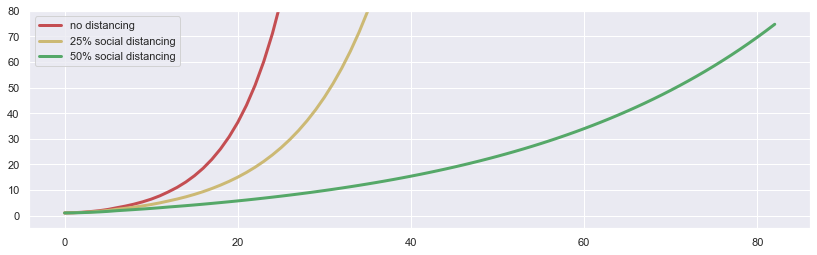

In [535]:
plt.plot(total_infected(covid(D_m)), 'r', label='no distancing');
plt.plot(total_infected(covid_q(D_m, 0.25)), 'y', label=r'25% social distancing');
plt.plot(total_infected(covid_q(D_m, 0.5)), 'g', label=r'50% social distancing');
plt.legend();
plt.gca().set_ylim([-5,80]);

Of course the trends are still exponential, but this slower growth rate is what buys us time to act on the infrastructure of the health care system and on the research for new therapies.

## When does it end?

Clearly, no natural system can support a purely exponential growth. In the case of a viral epidemics, as more and more people contract the disease and either die or achieve immunity, the rate of transmission for the infection progressively decreases as the number of still healthy subjects becomes smaller. 

If the rate of diffusion is assumed to be inversely proportional to the fraction of healthy people in a population, the evolution of the cumulative number of infections since the beginning of the disease can be modeled by a _logistic function_ of the form:

$$y(t) = \frac{1}{1 + e^{-t}}$$

The function starts off as an exponential growth but then flattens out to a maximum value (which in the case of an epidemic, must be at most equal to the total number of individuals in a closed population).

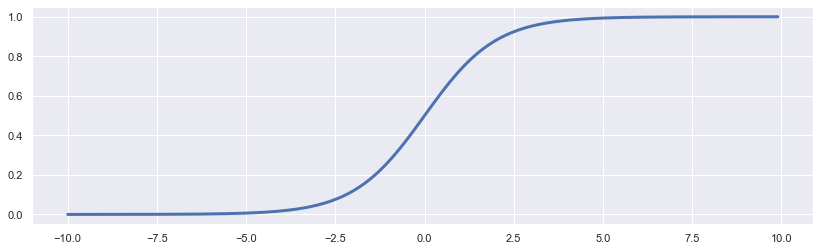

In [536]:
t = np.arange(-10, 10, 0.1)
plt.plot(t, 1 / (1 + np.exp(-t)));

In our case, we need to generalize the logistic function to take into account the following parameters:
 * the total size $K$ of the population
 * the basic reproduction number $R_0$
 
It can be shown that the following expression fits the bill:

$$y[n] = \frac{K}{1 + [K(R_0 - 1) - R_0]R_0^{-(n+1)}} - \frac{1}{R_0 - 1}$$

In [537]:
def logistic(t, R, K):
    return K / (1 + (K * (R-1) - R) / np.power(R, t+1)) - 1 / (R-1)

Let's choose a milder $R_0$ than before and plot the evolution of a standard exponential epidemic versus the logistic evolution for a population of one million; note how the second plot shows that the exponential and the logistic are practically indistinguishable until the 50th day:

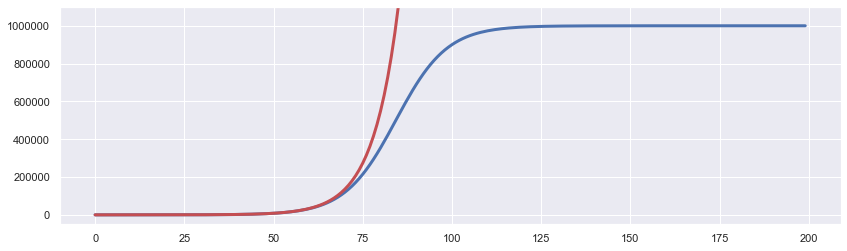

In [538]:
R = 1.15
K = 1E06

D = 200
plt.plot(logistic(np.arange(0, D), R, K), 'b')
plt.plot(total_infected(contagion(R, D)), 'r');
plt.gca().set_ylim([-0.05 * K, 1.1 * K]); 

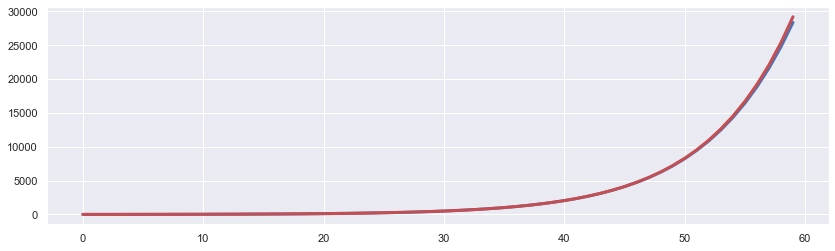

In [539]:
D_z = 60
plt.plot(logistic(np.arange(0, D_z), R, K), 'b')
plt.plot(total_infected(contagion(R, D_z)), 'r');

The interesting thing about the logistic function is that it has a clear inflection point, after which the epidemic starts to level out; this corresponds to the moment in which the implicit reproduction number becomes less than one. Clearly it's extremely interesting to indentify this point since it indicates that the epidemic is under control.

The inflection point corresponds to the global maximum of the first derivative of the logistic; we can approximate the derivative with a simple two-tap FIR filter of the form

$$ H(z) = 1 - z^{1}$$.

We can also look directly at the zero-crossing of the second derivative, approximated with the FIR

$$H_2 = 1 - 2z^{-1} + z^{-2}$$.

In both cases, the location of the inflection point is easily detectable, at least in the case of our idealized data sequence:

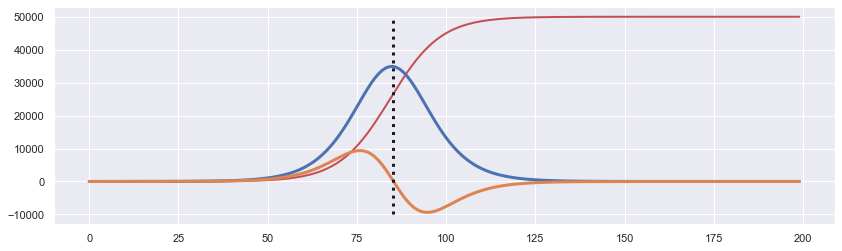

In [540]:
x = logistic(np.arange(0, D), R, K)
x1 = sp.lfilter([1, -1], [1] , x)
plt.plot(0.05 * x, 'r', linewidth=2);
plt.plot(x1);
plt.plot(5 * sp.lfilter([1, -2, 1], [1] , x));

ix = np.argmax(x1)
plt.plot([ix, ix], [-10000, 50000], 'k:')

In reality, however, things are not so simple. Epidemilogical data are usual noisy and lacunary, and it is very difficult to determine the position of the inflexion _during_ the unfolding of the epidemic. 

Consider for example the following data series, recording the cumulative cases of the 2003 SARS epidemics in Hong Kong ([source](https://www.kaggle.com/imdevskp/sars-outbreak-2003-complete-dataset#sars_2003_complete_dataset_clean.csv)):

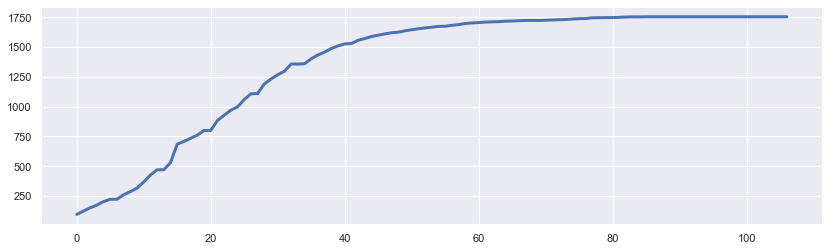

In [541]:
hk_sars = np.array([95, 123, 150, 173, 203, 222, 222, 260, 286, 316, 367, 425, 470, 470, 530, 685, 708, 734, 761, 800, 800, 883, 
                    928, 970, 998, 1059, 1108, 1110, 1190, 1232, 1268, 1297, 1358, 1358, 1360, 1402, 1434, 1458, 1488, 1510, 1527, 
                    1530, 1557, 1572, 1589, 1600, 1611, 1621, 1625, 1637, 1646, 1654, 1661, 1667, 1674, 1675, 1683, 1689, 1698, 
                    1703, 1706, 1710, 1712, 1714, 1718, 1719, 1722, 1724, 1724, 1724, 1726, 1728, 1730, 1732, 1736, 1739, 1740, 
                    1746, 1747, 1748, 1748, 1750, 1753, 1754, 1754, 1755, 1755, 1755, 1755, 1755, 1755, 1755, 1755, 1755, 1755, 
                    1755, 1755, 1755, 1755, 1755, 1755, 1755, 1755, 1755, 1755, 1755, 1755], dtype='float')

plt.plot(hk_sars);

If we try to approximate the first and second derivatives as before, we obtain the following plot:

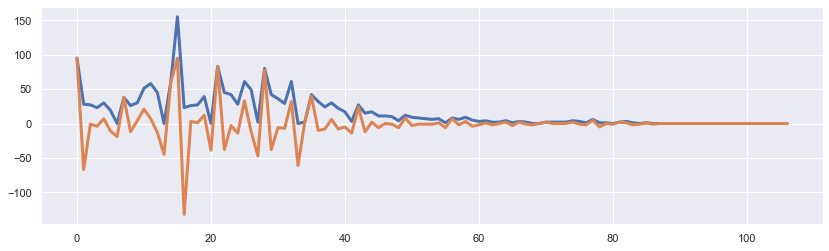

In [542]:
d1 = sp.lfilter([1, -1], [1] , hk_sars)
d2 = sp.lfilter([1, -2, 1], [1] , hk_sars)

plt.plot(d1);
plt.plot(d2);

It is evident that there are a lot of local maxima in the first-order difference of the dataset (and, correspondingly, a lot of zero-crossing in the second-order difference). We can try to use a better approximation for the differentiator and, indeed, the resulting graph are less noisy; nevertheless it should be apparent that the global maximum can only be determined with the benefit of hindsight...

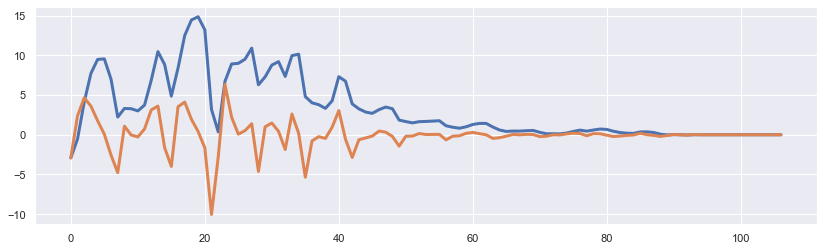

In [543]:
# linear phase differentiator designed with the Parks-McClellan algorithm via h=firpm(8,[0 .3 .4 1],[0 .2 0 0],'differentiator');
df = np.array([-0.030642265626632, 0.034111425417639, 0.047647971183923, 0.021611504008194, 0, 
               -0.021611504008194, -0.04764797118392, -0.034111425417639, 0.030642265626632])

d1 = sp.lfilter(df, [1] , hk_sars)
d2 = sp.lfilter([1, -1], [1] , d1)

plt.plot(d1);
plt.plot(d2);